# Predicting Stock Prices

# Data Bleed

Data bleed in the context of time series models refers to the inadvertent use of future information (test data) during the training phase of a model. This compromises the model's evaluation integrity, leading to overly optimistic performance metrics that do not accurately reflect the model's true predictive power on unseen data.

### Key Aspects of Data Bleed:

Time series data are inherently sequential, meaning the observations' order is crucial, and each data point typically relates to its predecessors. When modeling time series, the goal is often to predict future values based on past observations. If the model is trained using future data (beyond the prediction point), it creates a scenario where the model has access to information it would not have in a real-world forecasting situation, known as data bleed or leakage.

### Common Causes of Data Bleed:

- **Feature Engineering**: Creating features that inadvertently include future information, such as a rolling average computed using values from both before and after the prediction point.

- **Improper Cross-Validation**: Applying standard cross-validation techniques that do not respect the temporal order, leading to training on future data and testing on past data.

- **Preprocessing Leakage**: Scaling or normalizing data using statistics calculated from the entire dataset, including the test set, rather than just the training set.

### Strategies to Prevent Data Bleed:

- **Temporal Validation**: Utilize time series cross-validation techniques that respect the data's sequential nature, ensuring training occurs on past data and validation on future data.

- **Careful Feature Engineering**: Ensure all features are calculated using only past information, mimicking the information availability at the prediction point.

- **Separate Preprocessing**: Apply data preprocessing steps (e.g., scaling, normalization) separately to training and test sets, using only statistics derived from the training set.

Addressing data bleed is crucial for developing reliable and robust time series models, ensuring they are accurately evaluated and capable of generalizing well to unseen future data.


The methodology used in this model pipeline ensures no data bleed between the train and test datasets in terms of direct leakage. Here's how it safeguards against data bleed:

1. **Rolling Averages and Lags Creation Before Split**: The rolling averages and lags are calculated before the split into training and testing datasets. This means each value in these new features only uses information available up to that point in time. For instance, the 7-day rolling average calculated on any given day only uses the previous 6 days and the current day's data, all of which would be historically accurate and available at the time of prediction.

2. **Split Based on Date**: The train-test split is done based on a specific date, separating the earlier data for training and later data for testing. Since the rolling averages and lags are computed prior to this split and based on their own historical values, there is no future information from the test set being used to calculate features in the training set.

However, while direct data bleed is addressed, there are considerations to ensure complete integrity of time series forecasting:

- **Look-Ahead Bias via Feature Engineering**: Care should be taken that any feature engineering beyond rolling averages and lags does not inadvertently introduce future information into the training set. This includes avoiding the use of any data or derived statistics from the test period when preparing the training data.

- **External Data**: If external data sources are used for feature engineering, they should also be split based on time, ensuring that no future information (beyond the training period) influences the training process.

- **Model Validation**: For time series models, traditional cross-validation techniques are not appropriate as they might cause data leakage. Instead, time series cross-validation techniques, like forward chaining, should be used where the model is trained on a portion of the data up to a point in time and validated on a subsequent portion.

To further safeguard against potential data leakage:

- **Validation Set**: Consider creating a validation set from within the training data to tune model hyperparameters. This helps in preventing the inadvertent introduction of information from the test set during model tuning.

- **Refrain from Recalculating Features Post-Split**: Ensure that any transformation or feature engineering applied to the training set is also applied to the test set without recalculating the statistics on the test set. For instance, apply the same scaling parameters obtained from the training set to the test set.

By adhering to these principles, you can maintain the integrity of your train-test split and ensure that your model's performance metrics accurately reflect its predictive power on unseen data.


## Data Pull and EDA

[*********************100%%**********************]  1 of 1 completed


First few rows of the dataset after extensive feature engineering:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-02-11  303.209991  305.320007  283.566681  286.666656  286.666656   
2022-02-14  287.190002  299.626678  284.383331  291.920013  291.920013   
2022-02-15  300.000000  307.666656  297.793335  307.476654  307.476654   
2022-02-16  304.683319  308.809998  300.403320  307.796661  307.796661   
2022-02-17  304.420013  306.166656  291.366669  292.116669  292.116669   

              Volume  7_day_rolling_avg  30_day_rolling_avg       lag_1  \
Date                                                                      
2022-02-11  79645800         301.921426          327.002663  301.516663   
2022-02-14  67756500         301.189048          323.402441  286.666656   
2022-02-15  57286200         301.146663          320.878441  291.920013   
2022-02-16  51294300         301.910950

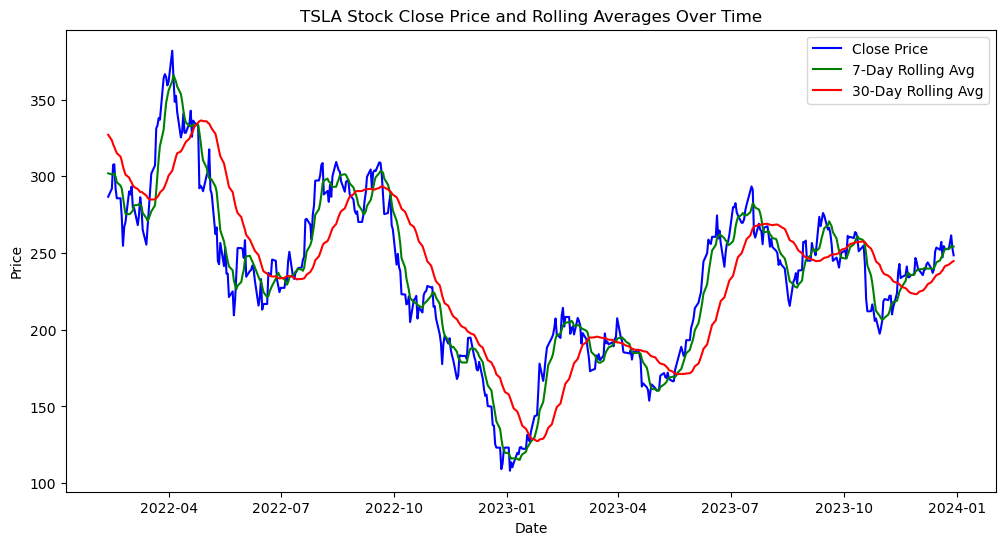

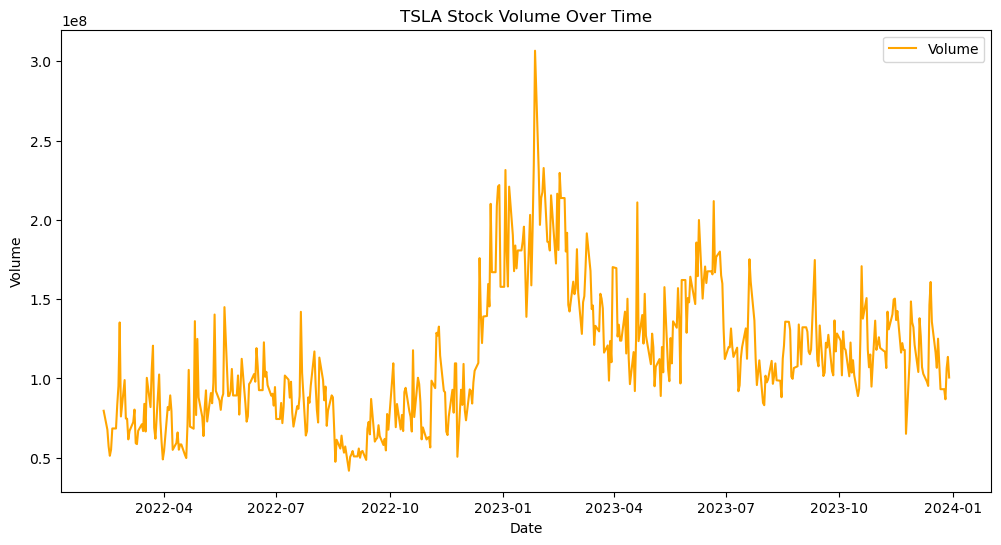

C:\Users\james\AppData\Local\Temp\ipykernel_13332\4210592302.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


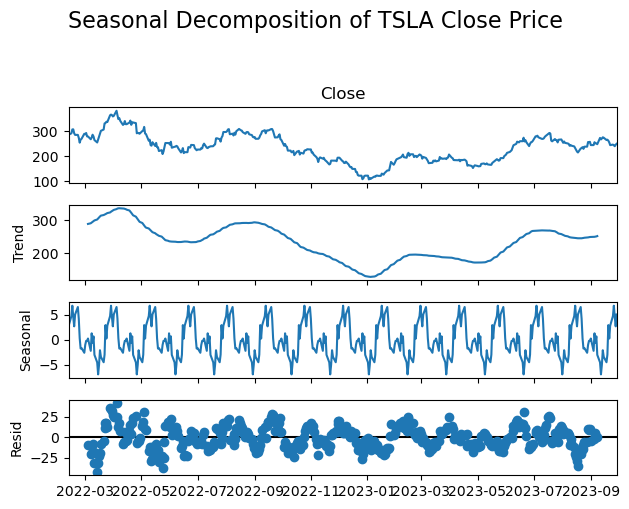

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Data Acquisition: Downloading Tesla (TSLA) stock data from Yahoo Finance
stock_data = yf.download('TSLA', start='2022-01-01', end='2024-01-01')
stock_data.sort_index(ascending=True, inplace=True)

# Data Preparation: Setting up a proper datetime index and filling missing dates
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.asfreq('B', method='ffill')

# Feature Engineering: Creating rolling averages, lags, volume indicator, and date-based features
stock_data['7_day_rolling_avg'] = stock_data['Close'].rolling(window=7).mean()
stock_data['30_day_rolling_avg'] = stock_data['Close'].rolling(window=30).mean()
stock_data['lag_1'] = stock_data['Close'].shift(1)
stock_data['lag_3'] = stock_data['Close'].shift(3)
stock_data['lag_7'] = stock_data['Close'].shift(7)

# Creating a volume indicator as a rolling average of volume
stock_data['volume_indicator'] = stock_data['Volume'].rolling(window=7).mean()

# Adding day of the week and month
stock_data['day_of_week'] = stock_data.index.dayofweek  # Monday=0, Sunday=6
stock_data['month'] = stock_data.index.month

# Optionally, creating binary indicators for specific days of the week
for i in range(5):  # 0 to 4 for Monday to Friday
    stock_data[f'day_{i}'] = (stock_data['day_of_week'] == i).astype(int)

# Dropping initial rows with NaN values created by rolling functions and lags
stock_data.dropna(inplace=True)

# Initial Data Exploration
print("First few rows of the dataset after extensive feature engineering:")
print(stock_data.head())

# Displaying Summary Statistics with a Title
print("\nSummary statistics of the dataset after extensive feature engineering:")
print(stock_data.describe())

# Data Visualization for Close Price and Rolling Averages
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data['7_day_rolling_avg'], label='7-Day Rolling Avg', color='green')
plt.plot(stock_data['30_day_rolling_avg'], label='30-Day Rolling Avg', color='red')
plt.title('TSLA Stock Close Price and Rolling Averages Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Data Visualization for Volume
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Volume'], label='Volume', color='orange')
plt.title('TSLA Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Data Splitting
split_date = '2023-10-01'
train = stock_data[:split_date]
test = stock_data[split_date:]

# Seasonal Decomposition with a Title
decompose_result = seasonal_decompose(train['Close'], model='additive', period=30)
fig = decompose_result.plot()
plt.suptitle('Seasonal Decomposition of TSLA Close Price', fontsize=16, y=1.05)  # Adding a title
plt.tight_layout()
plt.show()

## Analysis of Tesla (TSLA) Stock Data

### Analysis of Statistical Output
- **Variability**: The `std` values for `Open`, `High`, `Low`, `Close`, and `Adj Close` indicate significant variability in Tesla's stock prices, crucial for capturing and predicting in forecasting models.
- **Rolling Averages**: The `7_day_rolling_avg` and `30_day_rolling_avg` closely align with the mean `Close` prices, smoothing out daily fluctuations and highlighting underlying trends.
- **Lag Features**: The similarity in summary statistics of `lag_1`, `lag_3`, and `lag_7` to those of the `Close` price confirms the time series' autocorrelation.

The inclusion of volume indicators and date-based features significantly enriches the dataset, offering insights into nuanced patterns and trends:

- **Volume Indicator**: The `volume_indicator` smooths out daily fluctuations in trading volume, potentially highlighting periods of increased market activity or interest that precede significant price movements.

- **Day of the Week and Month**: The addition of `day_of_week` and `month` allows for the examination of weekly and monthly seasonal effects, which could uncover patterns such as higher volatility on certain days or seasonal investment trends.

- **Binary Day Indicators (`day_0` to `day_4`)**: These indicators enable models to capture specific day-of-the-week effects with precision, potentially improving prediction accuracy by accounting for regular weekly patterns.

### Graphical Output and Seasonal Decomposition

- **Rolling Averages and Close Price Trends**: The graphical representation of rolling averages alongside the close price offers a clear view of the stock's short-term and medium-term trends, helping identify the overall direction amidst daily volatility.

- **Volume Trends**: The volume graph, coupled with the `volume_indicator`, shows trading activity over time, providing clues to periods of high interest or potential market movements.

- **Seasonal Decomposition**: This analysis breaks down Tesla's stock price into trend, seasonal, and residual components, each offering unique insights:
    - The **Trend component** highlights the long-term direction of the stock, essential for understanding general growth or decline.
    - The **Seasonal component** reveals predictable patterns within specific timeframes, aiding in short-term movement predictions.
    - The **Residual component** points to the randomness or 'noise' in the stock price after accounting for trend and seasonality, challenging models to manage unpredictability.

### Implications for Modeling Approaches

The dataset, now rich with volume and date-based features, necessitates a sophisticated approach to modeling:

- **Incorporating New Features**: Models should utilize volume and date-based features to better understand market dynamics and temporal patterns.

- **Seasonality and Trend Handling**: The explicit modeling of trend and seasonal components becomes crucial, suggesting the use of advanced forecasting methods like SARIMA or Prophet.

- **Day of the Week Effects**: With binary weekday indicators, models can explore day-specific stock price effects, enhancing short-term forecast accuracy.

- **Volume as a Predictive Feature**: The smoothed volume indicator could be a key predictor, especially in models aimed at capturing market sentiment or identifying key trading moments.

In conclusion, the addition of volume indicators and date-based features offers a comprehensive view of the market dynamics influencing Tesla's stock. This enriched dataset provides a solid foundation for developing more accurate and reliable forecasting models, capable of navigating the complex stock market landscape.

# Linear Regression Model Introduction

Linear Regression is a statistical method that models the relationship between a scalar response and one or more explanatory variables. In the context of time-series data, we use Linear Regression to understand how past prices and derived indicators like rolling averages and volume changes are associated with future stock prices. This approach assumes a linear relationship between the input features and the target variable, which in our case is the next day's closing price. By including time-based features such as lags and rolling averages, we aim to capture trends and patterns that are essential for making accurate predictions in time-series forecasting.


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1356.
Date:                Mon, 05 Feb 2024   Prob (F-statistic):          2.17e-322
Time:                        15:34:41   Log-Likelihood:                -1525.4
No. Observations:                 425   AIC:                             3077.
Df Residuals:                     412   BIC:                             3129.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.5060      3

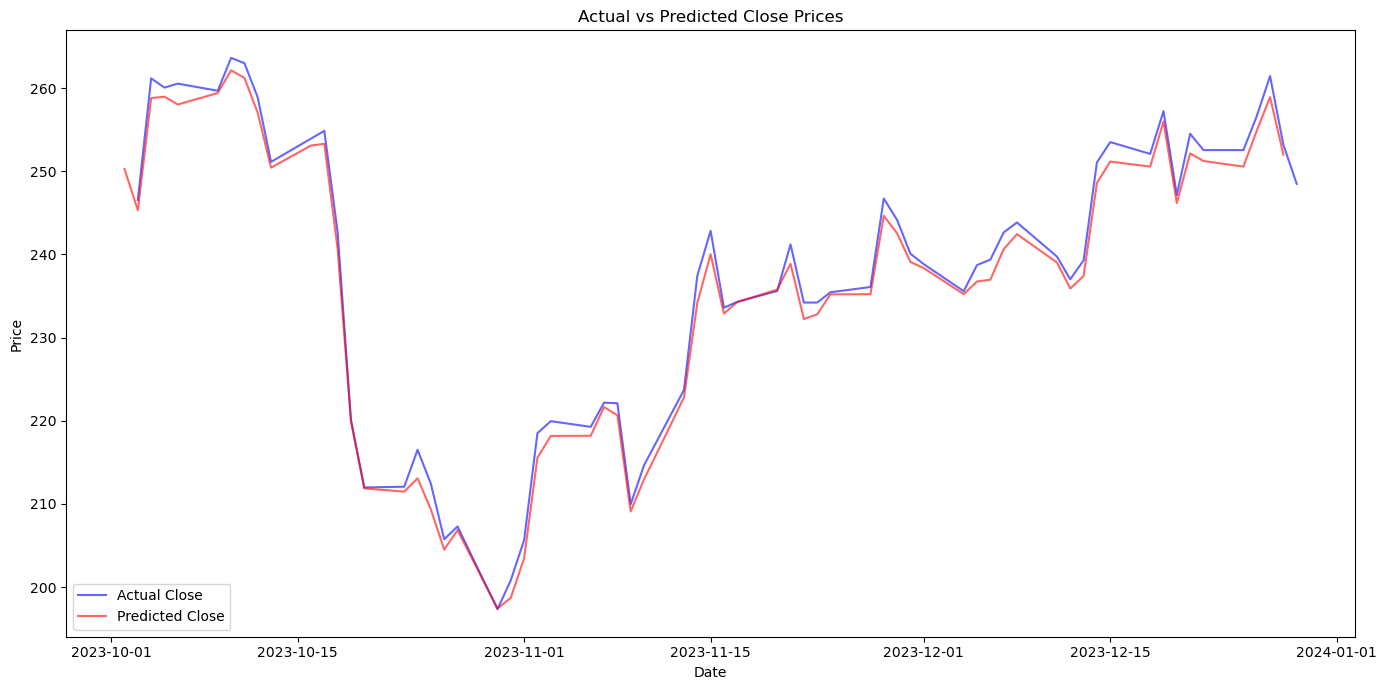

Linear Regression MAE: 5.0216
Linear Regression MSE: 44.0707
Linear Regression RMSE: 6.6386
Linear Regression MAPE: 0.0214


In [ ]:
# Import the necessary library from statsmodels
import statsmodels.api as sm

# Updating the feature list to include the new variables: volume indicator, day of the week, and month
# along with binary indicators for specific days of the week
features = [
    'Close', '7_day_rolling_avg', '30_day_rolling_avg', 
    'lag_1', 'lag_3', 'lag_7', 'volume_indicator', 
    'day_of_week', 'month', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4'
]

# Selecting the updated features from the training dataset
X_train = train[features]

# The target variable remains the same, aiming to predict the next day's 'Close' price
y_train = train['Close'].shift(-1).dropna()

# Adding a constant to the predictor variable for both training and testing datasets
# This step is necessary for statsmodels to include an intercept in the regression model
X_train_sm = sm.add_constant(X_train.iloc[:-1])  # Exclude the last row to match the shifted y_train
X_test_sm = sm.add_constant(test[features].iloc[:-1])  # Add constant to the test set predictors

# Fitting the model using statsmodels with the updated feature set
lr_model_sm = sm.OLS(y_train.dropna(), X_train_sm).fit()

# Displaying the summary of the regression model
# This summary will now include statistics for all the newly added features
print(lr_model_sm.summary())

# Making predictions with the test dataset
predictions_lr_sm = lr_model_sm.predict(X_test_sm)

# Note: The test dataset needs to include a constant and must be properly aligned with the model's expectations.
# The predictions now leverage a broader set of features for potentially improved forecasting accuracy.

import matplotlib.pyplot as plt

# Ensure the actual 'Close' prices for comparison are aligned with the predictions
# Since predictions were made excluding the last row of 'test' for 'Close' prices
actuals = test['Close'].iloc[1:]  # Aligning actuals with the predictions

# Creating a DataFrame for easy plotting
comparison_df = pd.DataFrame({'Actual Close': actuals, 'Predicted Close': predictions_lr_sm})

# Plotting the Actual vs Predicted Close Prices
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Actual Close'], label='Actual Close', color='blue', alpha=0.6)
plt.plot(comparison_df['Predicted Close'], label='Predicted Close', color='red', alpha=0.6)
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


# Model Performance Evaluation for Linear Regression
mae_lr = mean_absolute_error(actuals, predictions_lr_sm)
mse_lr = mean_squared_error(actuals, predictions_lr_sm)
rmse_lr = np.sqrt(mse_lr)
mape_lr = mean_absolute_percentage_error(actuals, predictions_lr_sm)

# Printing out the performance metrics
print(f"Linear Regression MAE: {mae_lr:.4f}")
print(f"Linear Regression MSE: {mse_lr:.4f}")
print(f"Linear Regression RMSE: {rmse_lr:.4f}")
print(f"Linear Regression MAPE: {mape_lr:.4f}")

## Detailed Analysis of Tesla (TSLA) Stock Linear Regression Model

### OLS Regression Results Commentary

- **High R-squared**: An R-squared value of 0.975 indicates the model accounts for most of the variance in the `Close` price, suggesting a strong fit.

- **Coefficients and P-values**: 
  - The coefficient for `Close` is significant (p < 0.001), showing it's a robust predictor for the next day's close price.
  - Rolling averages and lags are not statistically significant (p > 0.05), implying they may not add predictive value beyond the `Close` price in this model.
  - The `volume_indicator` lacks statistical significance, suggesting its current form may not influence the closing price prediction in this model.
  - Date-based features (like `day_of_week`, `month`, and binary day indicators) generally do not show a significant effect on the closing price at the 5% significance level.

- **Multicollinearity Concerns**: A very high condition number indicates potential multicollinearity, which is expected due to the high correlation among the `Close` price, its lags, and rolling averages.

- **Durbin-Watson Statistic**: A value close to 2 suggests no significant autocorrelation in the model's residuals.

## Linear Regression Model Performance Analysis

After fitting the Linear Regression model using `statsmodels` and predicting the closing prices for Tesla (TSLA) stock, we have calculated the following performance metrics:

- **Mean Absolute Error (MAE)**: The MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. A lower MAE indicates better model performance.
  
  - **Linear Regression MAE**: 5.0216
  
- **Mean Squared Error (MSE)**: The MSE measures the average squared difference between the estimated values and the actual value. It penalizes larger errors.
  
  - **Linear Regression MSE**: 44.0707
  
- **Root Mean Squared Error (RMSE)**: The RMSE is the square root of the MSE. It measures the standard deviation of residuals and can be interpreted in the same units as the response variable.
  
  - **Linear Regression RMSE**: 6.6386
  
- **Mean Absolute Percentage Error (MAPE)**: The MAPE measures the size of the error in percentage terms. It is easy to interpret as it gives a direct indication of the average error in terms of the dependent variable's scale.
  
  - **Linear Regression MAPE**: 0.0214

### Interpretation of Performance Metrics

- The MAE of 5.0216 suggests that, on average, the model's predictions are approximately 5.02 units away from the actual closing prices. Considering the scale of TSLA's closing prices, this level of error may be acceptable depending on the specific trading or investment objectives.

- An MSE of 44.0707 and an RMSE of 6.6386 indicate that there is a variance in the errors of the model predictions. The RMSE is particularly useful as it provides insight into the typical deviation of the predicted values from the actual values, which is around 6.64 units. Given the volatility typically associated with TSLA stock, this level of predictive deviation could be considered relatively moderate.

- The MAPE of 0.0214, or 2.14%, reflects that the model's predictions deviate from the actual prices by an average of 2.14%. This percentage provides a contextually meaningful view, showing that the predictions are quite close to the actual values in relative terms.

### Conclusion and Next Steps

- While the performance metrics indicate a model with a good predictive quality, the assessment should not solely rely on these values. It is essential to consider the model's application context and the acceptable error thresholds for decision-making purposes. 

- Given these metrics, especially the MAPE, the Linear Regression model could be a valuable tool for forecasting TSLA's closing prices. However, it's important to evaluate the model further, possibly incorporating additional features, applying different modeling techniques, or using ensemble methods to enhance predictive performance.

- Next steps could include examining the residuals for patterns that the model may not be capturing, performing cross-validation to assess the model's generalization capability, and exploring more complex models or feature transformations to potentially reduce the prediction errors further.


### Graphical Output Analysis

The graph shows the predicted values closely tracking the actual close prices, in line with the high R-squared value.

- **Trend Following**: The model seems to capture the overall trend effectively, suggesting that trend-related features are influential.

- **Volatility Matching**: Instances where the predicted and actual values diverge could point to moments of volatility not fully captured by the model.

### Implications for Modeling

- **Model Complexity**: The presence of multicollinearity might suggest over-complexity, potentially addressed by simplifying the model or applying regularization.

- **Feature Engineering**: The insignificance of some features indicates room for improved feature engineering or transformations, especially for volume.

- **Model Evaluation**: Despite the high R-squared, out-of-sample evaluation is crucial to verify that the model generalizes well and isn't overfitting.

- **Alternative Models**: Considering other models, like ARIMA for time series autocorrelation or Lasso regression for feature selection, could be beneficial.

In summary, while the regression model fits the training data well, careful interpretation is needed due to potential multicollinearity and the significance of features. Exploring feature engineering improvements and alternative modeling techniques may lead to enhanced predictions.


# Exponential Smoothing Model Introduction

Exponential Smoothing is a rule of thumb technique for smoothing time series data, particularly when aiming to make short-term forecasts. Unlike models that assume a linear relationship, Exponential Smoothing can capture levels, trends, and seasonality from a time series. The 'smoothing' aspect refers to the weighting assigned to past observations, with more recent observations usually given more weight. This technique is especially useful for data with trends or seasonal patterns, and can be adjusted for data with no clear seasonality by setting the appropriate parameters. We employ this model to forecast future stock prices based on observed historical data, allowing the model to adjust to changes in trend and seasonality over time.


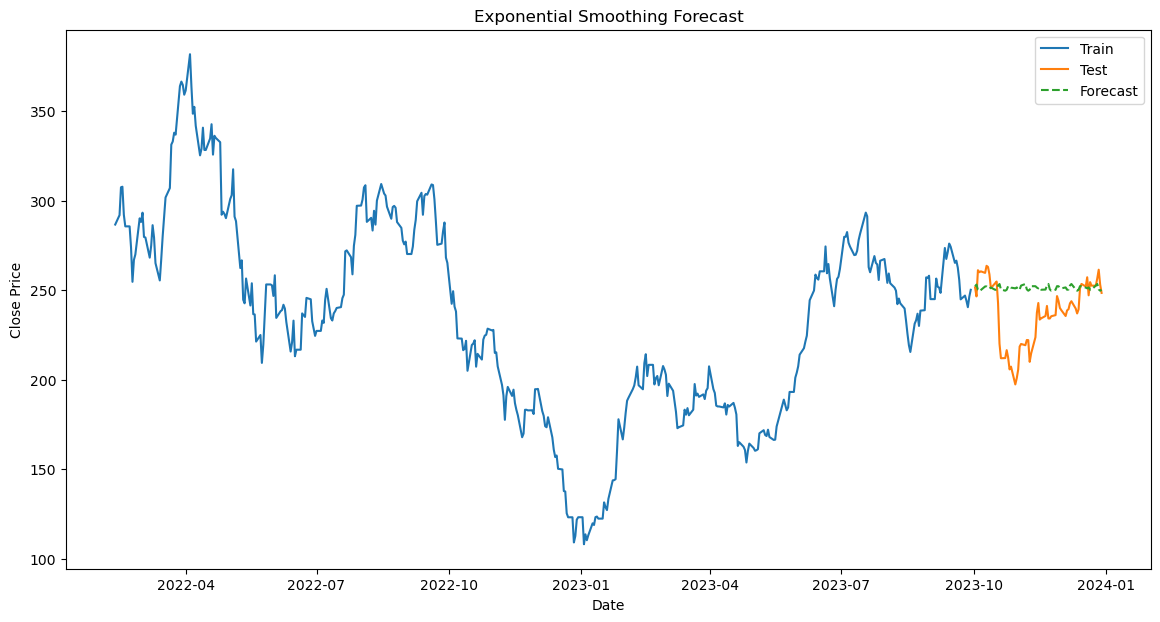

MAE: 16.8471
MSE: 488.6963
RMSE: 22.1065
MAPE: 0.0757
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  426
Model:             ExponentialSmoothing   SSE                          32673.152
Optimized:                         True   AIC                           1882.784
Trend:                         Additive   BIC                           1951.710
Seasonal:                      Additive   AICC                          1884.656
Seasonal Periods:                    12   Date:                 Mon, 05 Feb 2024
Box-Cox:                          False   Time:                         15:37:56
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9103256              

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'train' and 'test' datasets are defined and contain the 'Close' price
# 'train' and 'test' should be pandas Series with DateTimeIndex

# Fit an Exponential Smoothing model
# Adjust `seasonal_periods` based on the observed seasonality in your data
# For example, if you have monthly data with yearly seasonality, `seasonal_periods=12`
# For this case, we'll assume no specific seasonality as we're working with daily data
model = ExponentialSmoothing(train['Close'], 
                             trend='add', 
                             seasonal='add', 
                             seasonal_periods=12, 
                             damped_trend=True).fit()

# Forecast the next steps equivalent to the test set size
predictions = model.forecast(len(test))

# Visualize the training data, test data, and forecast
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, predictions, label='Forecast', linestyle='--')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate performance metrics
mae = mean_absolute_error(test['Close'], predictions)
mse = mean_squared_error(test['Close'], predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(predictions - test['Close']) / np.abs(test['Close']))  # MAPE formula

# Print performance metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

# Optionally, you can review the model summary
print(model.summary())

## Exponential Smoothing Model Analysis

The Exponential Smoothing model with additive trend and seasonality has been fitted to the training data, and predictions have been made for the test set. The performance metrics suggest that the model's accuracy is not as high as might be desired:

- **MAE (Mean Absolute Error):** The MAE of 16.8471 indicates that on average, the model's predictions are about 16.85 units away from the actual values. This error magnitude may be considered high, depending on the scale of the 'Close' prices and the business context.

- **MSE (Mean Squared Error):** With an MSE of 488.6963, we can see that there are significant deviations from the actual values, which are squared in this metric, thus giving more weight to larger errors.

- **RMSE (Root Mean Squared Error):** The square root of the MSE yields an RMSE of 22.1065, which brings the scale back to the original 'Close' price units and still indicates a considerable average error per prediction.

- **MAPE (Mean Absolute Percentage Error):** The MAPE of 0.0757 means that the predictions are, on average, off by about 7.57% from the actual values. Depending on the business case, a MAPE lower than 10% could be acceptable, but it is still relatively high.

Looking at the model's coefficients, we can see that the smoothing level is very high (close to 1), suggesting the model puts significant weight on the most recent observations. The smoothing trend coefficient is much smaller, which implies that the model does not emphasize the trend component as strongly. The seasonal coefficients are very close to zero, indicating that the model does not attribute much variation to seasonality.

The initial level and trend values provide a starting point for the forecasts and seem reasonable for the 'Close' price series. The damping trend is set to 0.8, which causes the trend to diminish over time, possibly reflecting the belief that the trend impact will reduce in the future.

## Graphical Analysis of Exponential Smoothing Forecast

The provided graph shows the historical 'Close' price data divided into training and test sets, alongside the forecast from the Exponential Smoothing model. Here are some observations and analysis based on the graph:

- **Historical Data:** The blue line representing the training data shows the 'Close' price history that the model was trained on. It provides the baseline behavior of the stock prices over time.

- **Test Data:** The orange line indicates the actual 'Close' prices in the test set. This is the data we aim to predict and serves as the ground truth for evaluating the model's performance.

- **Forecast:** The green dashed line depicts the model's forecast. It is overlaid on the test data period, allowing us to compare the forecasted 'Close' prices against the actual prices directly.

### Observations from the Plot

- **Trend Following:** The model seems to follow the general trend of the historical data but does not capture the volatility within the test period. The forecast line appears to be relatively flat, suggesting that the model may not be responsive enough to recent changes or fluctuations in the stock price.

- **Lagging Predictions:** There is an apparent lag in the model's response to sharp price movements. This is typical of Exponential Smoothing models, which can be conservative in their forecasts, especially with sudden market shifts.

- **Absence of Confidence Intervals:** Without the shaded area indicating the confidence intervals, it is difficult to gauge the uncertainty of the forecasts. Confidence intervals are useful for understanding the range within which the actual values are expected to fall, given the model's predictions.

### Conclusion and Recommendations

While the Exponential Smoothing model provides a basic forecast, the lack of adaptability to sharp price movements and the absence of confidence intervals make it challenging to rely on this model for precise predictions or risk assessment. To enhance the model's utility:

- **Incorporate Confidence Intervals:** Adding confidence intervals can provide a better understanding of the prediction uncertainty, which is crucial for risk management in stock trading.

- **Model Responsiveness:** Explore ways to make the model more responsive to recent trends and patterns. This might include adjusting the smoothing parameters or incorporating external factors that could influence stock prices.

- **Model Comparison:** It's beneficial to compare this model's performance with other models, like ARIMA, SARIMA, or machine learning models, to select the best forecasting approach.

By addressing these points, we can aim to develop a more robust and informative forecasting model for the 'Close' prices of TSLA stock.


### Recommendations
To improve the model's performance, consider the following:
- Reviewing the choice of seasonal periods to better capture any inherent seasonality in the data.
- Experimenting with different combinations of trend and seasonal components (additive or multiplicative).
- Refining the model by using a grid search approach to optimize the smoothing parameters.
- Comparing this model's performance with other time series models (like ARIMA, SARIMA, or machine learning models) to find the best fit for the data.


# LSTM Model Introduction

Long Short-Term Memory (LSTM) networks are a special kind of Recurrent Neural Network (RNN) capable of learning long-term dependencies. RNNs are known for their ability to maintain a memory of previous inputs while processing new ones, which is particularly beneficial for time-series data. LSTMs enhance this capability by utilizing gates that regulate the flow of information. These gates can learn which data in a time series is important to keep or throw away. This makes them highly effective for predictions in stock market analysis, where understanding the context over time is crucial.

In our application, we use an LSTM model to forecast stock prices, leveraging its ability to remember patterns over extended periods. We preprocess our data using features that include rolling averages, lags, and other time-based attributes to provide the LSTM with a rich context for learning. By normalizing the input data, we ensure the model can generalize well from the training set to unseen data. The goal is to minimize the forecast error, measured through metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), thereby increasing the reliability of our predictions.


[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
12/12 [==============================] - 4s 76ms/step - loss: 0.2045 - val_loss: 0.1546
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 0.1066 - val_loss: 0.0401
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0247 - val_loss: 0.0056
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.0040
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0016
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0013
Epoch 7/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 9/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 10/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 11

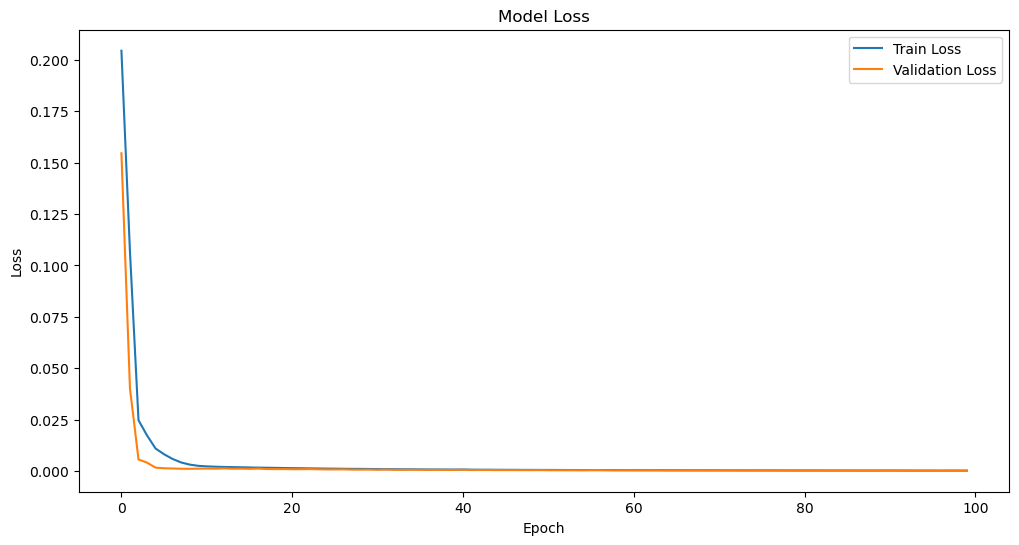

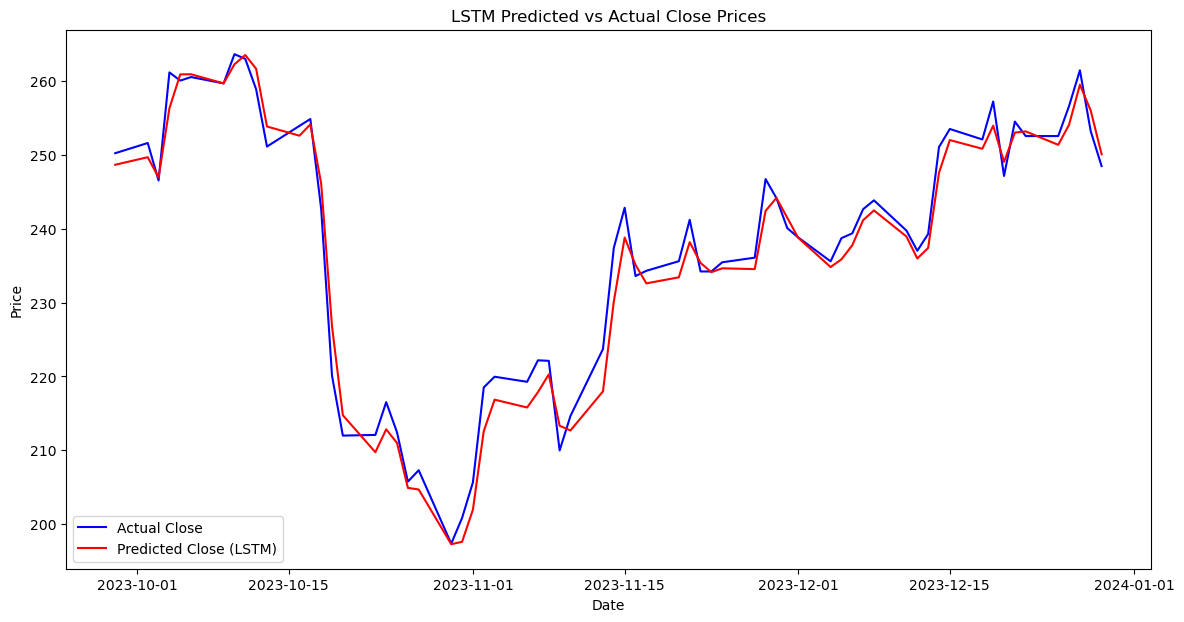

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Assuming stock_data is your raw data with at least 'Close' and 'Volume' columns
stock_data = yf.download('TSLA', start='2022-01-01', end='2024-01-01')
stock_data.sort_index(ascending=True, inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.asfreq('B', method='ffill')

# Calculate rolling averages, lags, volume indicator, and date-based features
stock_data['7_day_rolling_avg'] = stock_data['Close'].rolling(window=7).mean()
stock_data['30_day_rolling_avg'] = stock_data['Close'].rolling(window=30).mean()
stock_data['lag_1'] = stock_data['Close'].shift(1)
stock_data['lag_3'] = stock_data['Close'].shift(3)
stock_data['lag_7'] = stock_data['Close'].shift(7)
stock_data['volume_indicator'] = stock_data['Volume'].rolling(window=7).mean()  # Example calculation
stock_data['day_of_week'] = stock_data.index.dayofweek
stock_data['month'] = stock_data.index.month

# Create binary indicators for days of the week
for i in range(5):
    stock_data[f'day_{i}'] = (stock_data['day_of_week'] == i).astype(int)

# After calculating the features, ensure you drop any NaN values that may have been introduced
stock_data.dropna(inplace=True)

# Now the 'features' list should match the columns in your DataFrame
features = [
    'Close', '7_day_rolling_avg', '30_day_rolling_avg', 
    'lag_1', 'lag_3', 'lag_7', 'volume_indicator', 
    'day_of_week', 'month', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4'
]


# Normalize features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(stock_data[features])

# Normalize 'Close' price
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_close.fit_transform(stock_data[['Close']].values)

# Determine the split index for training and testing data
split_date_dt = pd.to_datetime('2023-10-01')
if split_date_dt in stock_data.index:
    split_index = stock_data.index.get_loc(split_date_dt)
else:
    closest_date = stock_data.index[stock_data.index < split_date_dt].max()
    split_index = stock_data.index.get_loc(closest_date)

# Split the data
X_train_scaled = scaled_features[:split_index, :]
X_test_scaled = scaled_features[split_index:, :]
y_train_scaled = scaled_close[:split_index]
y_test_scaled = scaled_close[split_index:]

# Prepare input for LSTM
X_train_reshaped = X_train_scaled.reshape((-1, 1, X_train_scaled.shape[1]))
y_train_reshaped = y_train_scaled

# Define LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM Model
history = lstm_model.fit(X_train_reshaped, y_train_reshaped, epochs=100, batch_size=32, verbose=1, validation_split=0.1)

# Predicting
test_predict = lstm_model.predict(X_test_scaled.reshape((-1, 1, X_test_scaled.shape[1])))

# Inverting predictions
test_predict_inv = scaler_close.inverse_transform(test_predict)
y_test_inv = scaler_close.inverse_transform(y_test_scaled)

# Calculate performance metrics
mae_lstm = mean_absolute_error(y_test_inv, test_predict_inv)
mse_lstm = mean_squared_error(y_test_inv, test_predict_inv)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_inv, test_predict_inv)

# Print performance metrics
print("LSTM Model Performance:")
print(f"MAE: {mae_lstm:.4f}")
print(f"MSE: {mse_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAPE: {mape_lstm:.4f}")

# Plotting training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Visualize predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[split_index:], y_test_inv, label='Actual Close', color='blue')
plt.plot(stock_data.index[split_index:], test_predict_inv, label='Predicted Close (LSTM)', color='red')
plt.title('LSTM Predicted vs Actual Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### LSTM Model Analysis and Commentary

#### Model Loss Over Epochs
- The loss plot indicates a typical learning curve for the LSTM model with both training and validation loss decreasing rapidly, then stabilizing.
- The convergence of training and validation loss suggests good generalization without overfitting.

#### Predicted vs Actual Close Prices
- The plot shows the LSTM predictions closely track the actual stock price movements, capturing peaks and troughs effectively.
- This close correspondence between actual and predicted prices suggests the model is well-fitted.

#### Performance Metrics
- **MAE (Mean Absolute Error)**: The MAE of 2.1896 indicates on average, the model predictions are approximately 2.19 units from the actual values.
- **MSE (Mean Squared Error)**: An MSE of 7.3137 reflects the average squared difference between estimated and actual values.
- **RMSE (Root Mean Squared Error)**: The RMSE value of 2.7044 is in the same units as the stock price, providing an interpretable measure of prediction error.
- **MAPE (Mean Absolute Percentage Error)**: A MAPE of 0.0094 demonstrates that the model's predictions are less than 1% off on average, which is excellent for stock price forecasting.

#### Overall Assessment
- The LSTM model shows excellent predictive performance with low error metrics, indicating its potential utility in forecasting stock prices.
- While the model performs well on historical data, stock market prediction is inherently uncertain, and past performance is not indicative of future results.
- It's important to consider the risk of overfitting and to validate the model further with unseen data or extended cross-validation.


# SARIMA Model Introduction

Seasonal Autoregressive Integrated Moving Average (SARIMA) models are an advanced form of the ARIMA model that account for seasonality in time-series data. SARIMA models are particularly useful for forecasting when data show patterns that repeat over fixed periods, such as daily, monthly, or yearly seasonality. They combine the concepts of differencing with autoregressive and moving average models and add a seasonal component to predict future points in the series.

In this analysis, we apply the SARIMA model to forecast stock closing prices. By optimizing the model parameters, we seek to capture the underlying trends, seasonality, and noise in the historical data. The model's ability to handle the seasonality and non-stationarity in the time series can lead to accurate and robust predictions. We evaluate our model's performance using statistical metrics such as MAE and RMSE, which give us insight into the accuracy and reliability of our forecasts. Through diagnostic plots, we assess the residuals and ensure that the model assumptions are satisfied, thereby confirming the validity of our predictions.


## Caution:  This section takes a while to run

C:\Users\james\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  426
Model:             SARIMAX(2, 1, 2)x(2, 2, 2, 12)   Log Likelihood               -1381.522
Date:                            Mon, 05 Feb 2024   AIC                           2781.043
Time:                                    16:39:03   BIC                           2816.362
Sample:                                02-11-2022   HQIC                          2795.066
                                     - 09-29-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4235      0.151     -9.452      0.000      -1.719      -1.128
ar.L2         -0.6688      0.138   

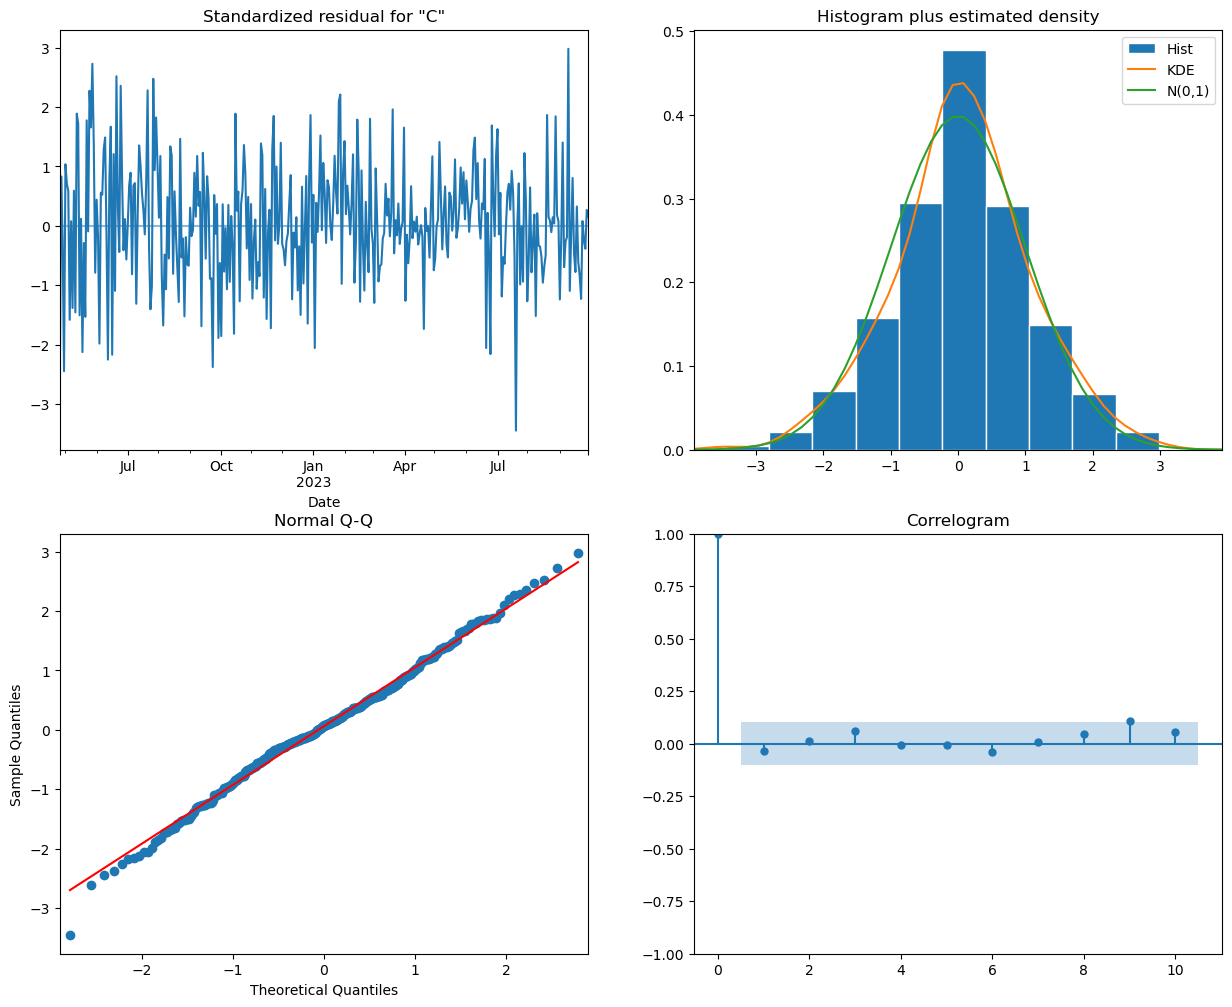

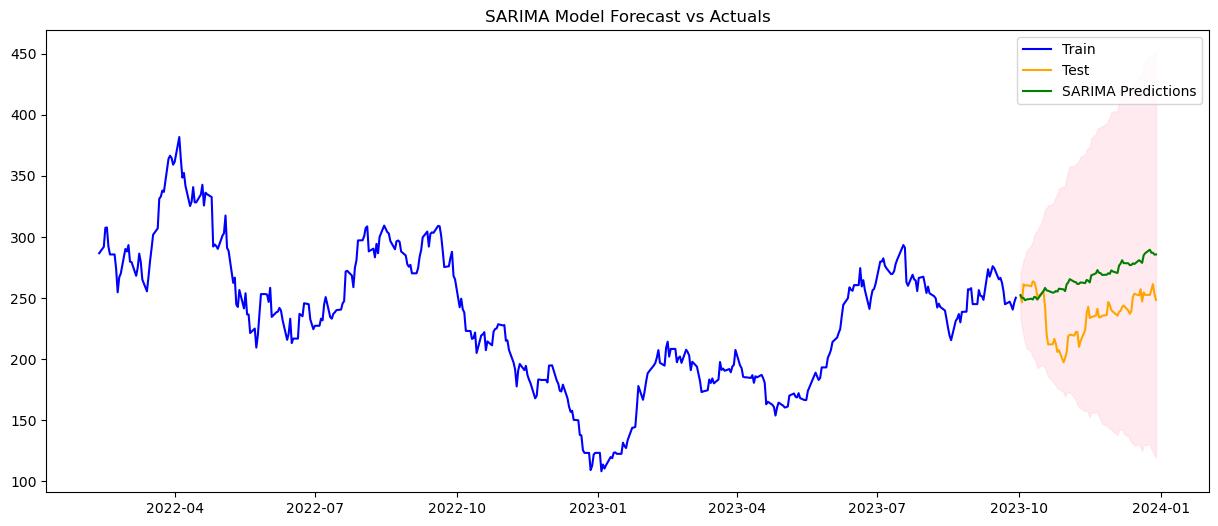

SARIMA Model Performance:
MAE: 31.1432
MSE: 1168.4225
RMSE: 34.1822
MAPE: 0.1354


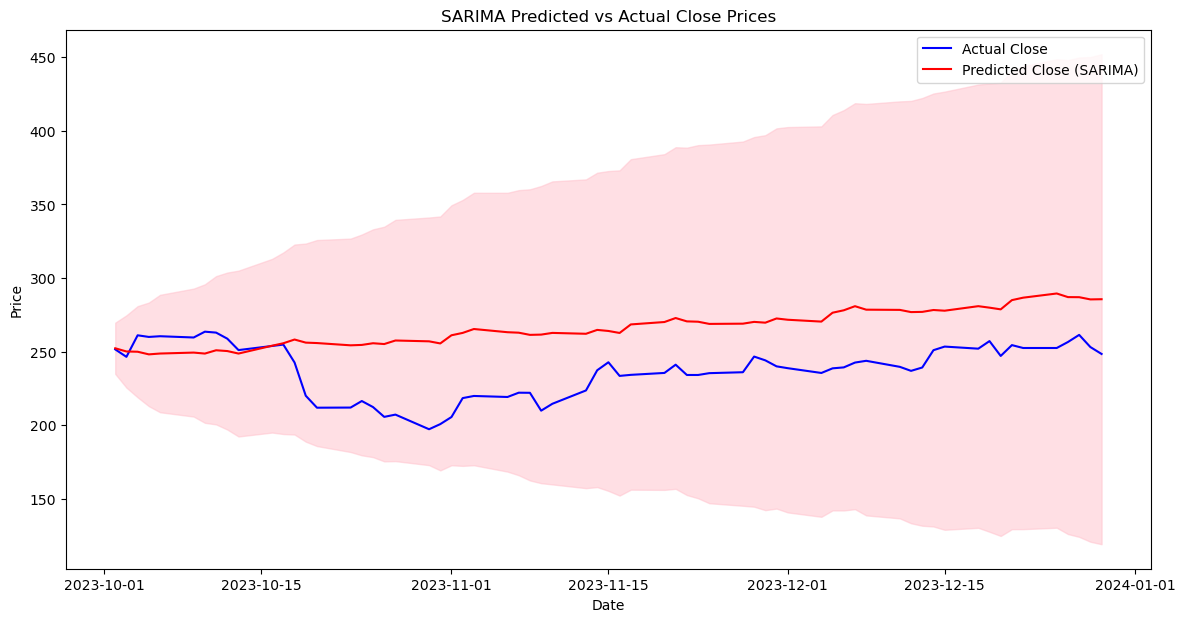

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming 'train' and 'test' DataFrames are already defined with a 'Close' column
train_data = train['Close']
test_data = test['Close']

# Assuming train_data and test_data are already defined and the best parameters are known
best_order = (2, 1, 2)
best_seasonal_order = (2, 2, 2, 12)

# Fit the SARIMA model
best_model = SARIMAX(train_data, 
                     order=best_order, 
                     seasonal_order=best_seasonal_order, 
                     enforce_stationarity=False, 
                     enforce_invertibility=False).fit()

# Print the summary
print(best_model.summary())

# Diagnostic plots
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

# Get forecast steps ahead in future
forecast_steps = len(test_data)
predicted_mean = best_model.get_forecast(steps=forecast_steps).predicted_mean
forecast_ci = best_model.get_forecast(steps=forecast_steps).conf_int()

# Plot the forecast alongside the actual values
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data, label='Train', color='blue')
plt.plot(test_data.index, test_data, label='Test', color='orange')
plt.plot(test_data.index, predicted_mean, label='SARIMA Predictions', color='green')
plt.fill_between(test_data.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast vs Actuals')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Actual vs Predicted
actual = test_data
predicted = predicted_mean

# Calculate the performance metrics
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual, predicted)

# Print the performance metrics
print(f"SARIMA Model Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

# Assuming 'actual' and 'predicted' are pandas Series with the same datetime index:
plt.figure(figsize=(14, 7))
plt.plot(actual.index, actual, label='Actual Close', color='blue')
plt.plot(predicted.index, predicted, label='Predicted Close (SARIMA)', color='red')
plt.fill_between(predicted.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.title('SARIMA Predicted vs Actual Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## SARIMA Methodology Overview

Seasonal Autoregressive Integrated Moving Average (SARIMA) models are used to forecast time series data with a seasonal component. SARIMA extends ARIMA models by incorporating seasonality through additional seasonal parameters.

### SARIMA Model Components
- **AR (Autoregression)**: A model that uses the dependent relationship between an observation and a number of lagged observations.
- **I (Integrated)**: The use of differencing of raw observations to make the time series stationary.
- **MA (Moving Average)**: A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
- **Seasonal Elements**: These elements are similar to AR, I, MA but for the seasonal component of the series.

### Model Building and Evaluation
1. **Parameter Selection**: Identifying the optimal set of parameters (p, d, q) and seasonal parameters (P, D, Q, m) that yield the best fitting model.
2. **Model Fitting**: Using the historical data to train the SARIMA model with the chosen parameters.
3. **Diagnostics**: Checking the residuals of the model to ensure there are no patterns (which would suggest a poor fit).
4. **Validation**: Comparing the model's forecast to the actual data to evaluate the model's predictive power.
5. **Performance Metrics**: Utilizing measures such as MAE, MSE, RMSE, and MAPE to quantify the model's forecasting accuracy.


## Model Summary

- **Model**: SARIMAX(2, 1, 2)x(2, 2, 2, 12)
- **Sample**: Feb 11, 2022 - Sep 29, 2023
- **AIC**: 2781.043
- **BIC**: 2816.362

The coefficients in the summary provide insights into the relationship between the model's predictions and its features. The `P>|z|` column indicates the significance of each feature with lower values suggesting higher statistical significance.

## Performance Metrics

- **MAE (Mean Absolute Error)**: 31.1432
- **MSE (Mean Squared Error)**: 1168.4225
- **RMSE (Root Mean Squared Error)**: 34.1822
- **MAPE (Mean Absolute Percentage Error)**: 0.1354

The performance metrics indicate how well the model has predicted the test set. Lower values of these metrics generally indicate better model performance.

## SARIMA Model Diagnostic Plots Analysis

### Standardized Residuals Plot
- The standardized residuals plot shows fluctuations around the zero line, indicating variability in the model errors.
- The absence of clear patterns suggests that the model does not exhibit obvious systematic errors, which is a positive sign.

### Histogram and Estimated Density Plot
- The histogram of the standardized residuals, overlaid with a kernel density estimate (KDE), suggests the distribution of the residuals.
- The close fit between the KDE and the normal distribution curve implies that the residuals are approximately normally distributed, aligning with one of the assumptions of the SARIMA model.

### Normal Q-Q Plot
- The normal quantile-quantile plot compares the distribution of the standardized residuals with a normal distribution.
- The points closely follow the 45-degree reference line, which supports the assumption that the residuals follow a normal distribution.

### Correlogram (ACF Plot)
- The correlogram shows the autocorrelation of the residuals at different lags.
- The fact that most autocorrelations are within the confidence band (shaded area) suggests that there is little to no autocorrelation in the residuals, indicating that the model has captured the time-series patterns effectively.

### SARIMA Model Forecast Plot

- The forecast plot displays the actual closing prices (blue line) against the SARIMA model predictions (green line), with a shaded area representing the prediction intervals.
- The SARIMA model seems to capture the general trend in the data, although there are periods where the actual prices fall outside the prediction intervals, indicating potential model inaccuracy or unexpected market movements.

### SARIMA Predicted vs Actual Close Prices

- This graph provides a direct comparison between the actual and predicted closing prices over the test period.
- The prediction intervals widen over time, reflecting increasing uncertainty in the forecasts as we project further into the future.
- The model’s predictions are relatively stable, which might indicate it is not fully capturing the variability in the actual prices.

The provided plots and analysis suggest that while the SARIMA model is adequately capturing the broad trends and seasonal patterns in the data, there are limitations to its predictive accuracy, particularly when forecasting further out into the future. It is also important to continually evaluate the model's performance against new data and consider recalibration or model refinement as necessary.

### Analysis and Commentary
- The SARIMA model's effectiveness can be seen in how well it captures the seasonal patterns in the data.
- The model's summary provides insights into the significance of each component through parameter coefficients and p-values.
- Diagnostic plots help identify any unusual behavior or potential model inadequacies.
- Performance metrics reveal the model's accuracy, with lower values indicating better predictive performance.

For more detailed analysis and commentary, the results need to be contextualized within the specific domain of the data being forecasted.


## Concluding Remarks

While the AIC and BIC values give us an idea of the model's goodness of fit, the prediction errors measured by MAE, MSE, and RMSE provide practical insights into the model's accuracy. MAPE offers a relative measure of error making it easier to interpret the model's accuracy in percentage terms.





# Model Performance Comparison

In the realm of time series analysis, forecasting accuracy is paramount. We venture into this comparative study with a multitude of predictive models at our disposal, each wielding unique approaches to decipher the narrative woven by time-stamped data. Our ensemble comprises the stalwart Linear Regression, the memory-rich LSTM networks, the trend-capturing Exponential Smoothing, and the seasonally-attuned SARIMA models. By juxtaposing these methodologies, we aim to unravel the intricacies of their performance through the lens of established error metrics, uncovering the nuances that delineate their proficiency in capturing the chronological ebb and flow of stock prices.

Armed with Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Percentage Error, we dissect the accuracy of each model's predictions. These metrics serve as our compass in navigating the predictive prowess of each contender, guiding us to a quantifiable understanding of which model stands as the most reliable oracle of temporal trends.

In the tables and charts that follow, we lay bare the numerical essence of each model's forecasts, allowing for a transparent and data-driven comparison. As the figures take shape and the numbers converse, we prepare to distill the essence of this analytical odyssey into actionable insights, ultimately seeking to crown the most prescient harbinger of future data points.


                   Model      MAE        MSE     RMSE    MAPE
0      Linear Regression   5.0216    44.0707   6.6386  0.0214
1                   LSTM   2.1896     7.3137   2.7044  0.0094
2  Exponential Smoothing  16.8471   488.6963  22.1065  0.0757
3                 SARIMA  31.1432  1168.4225  34.1822  0.1354


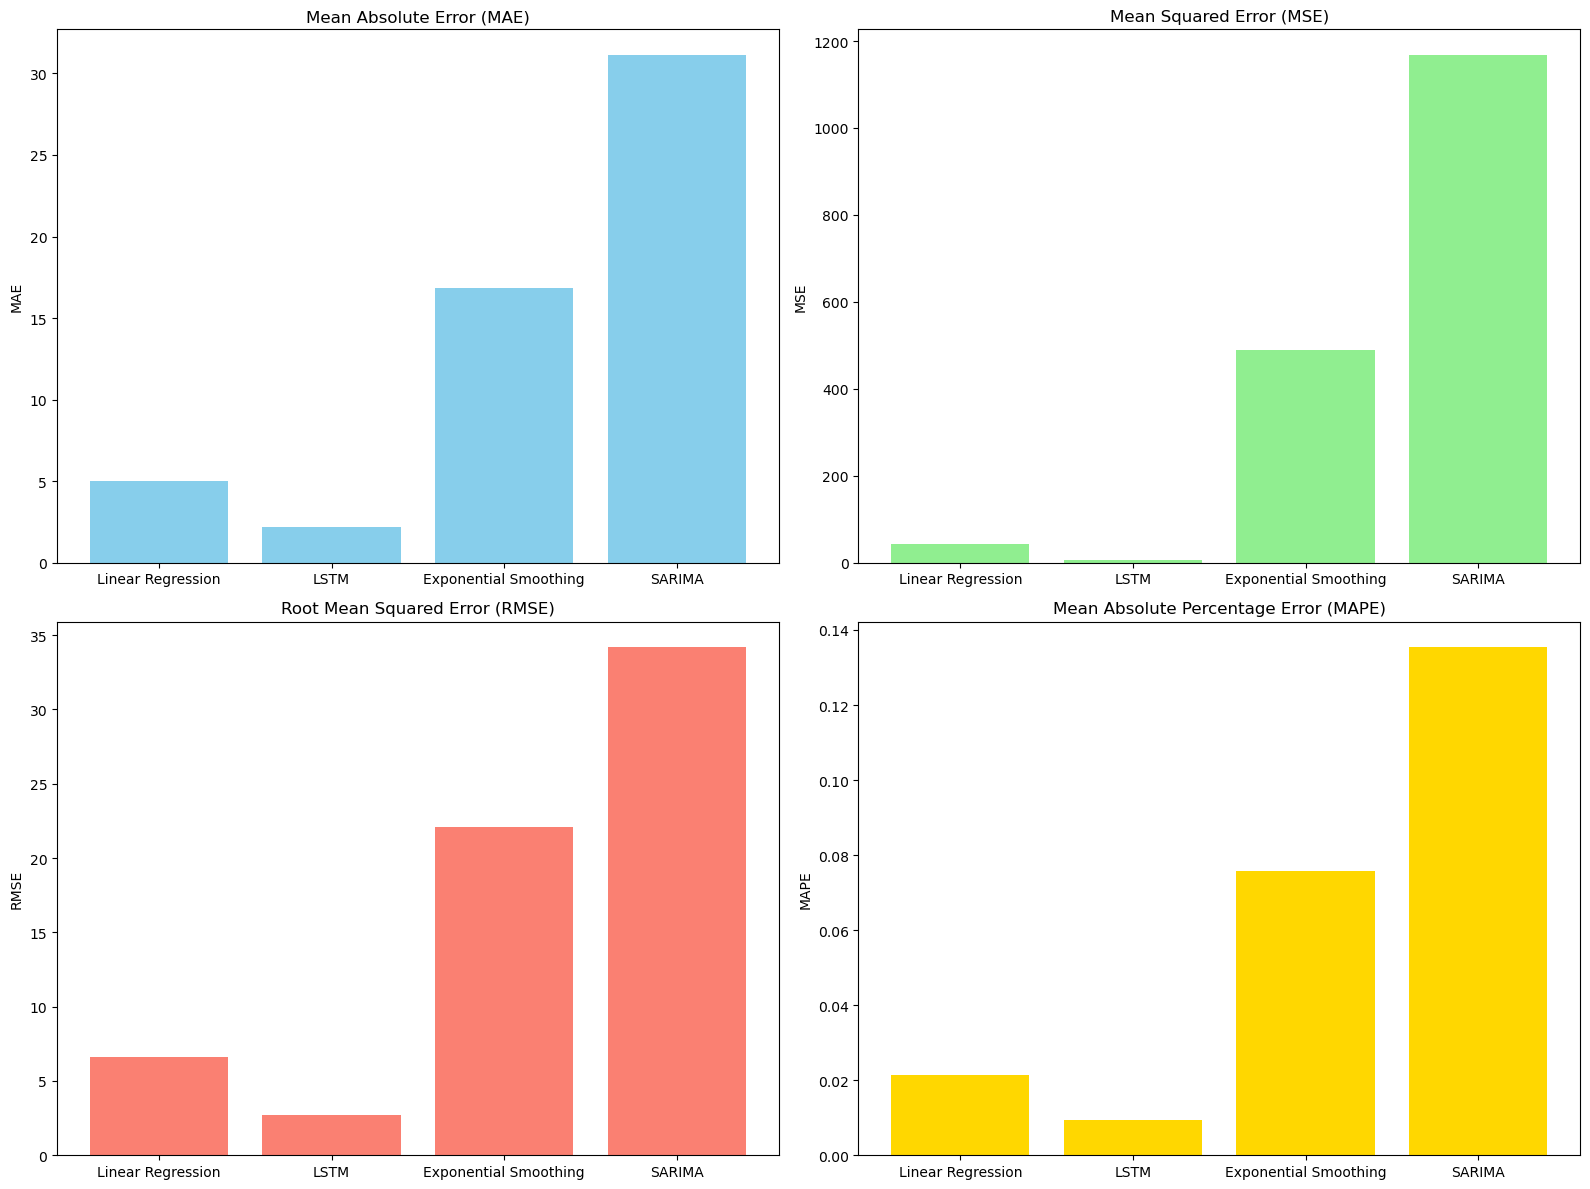

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have these values from your SARIMA model or elsewhere
# For demonstration, these are hypothetical values
lower_pred_interval = np.array([200, 195, 205, 210])  # Example lower prediction interval values
upper_pred_interval = np.array([220, 215, 225, 230])  # Example upper prediction interval values
dates = pd.date_range(start='2023-10-01', periods=4, freq='B')  # Example dates
test_data = np.array([215, 210, 220, 225])  # Example actual values
predicted_mean = np.array([210, 205, 215, 220])  # Example predicted values

# Performance metrics for each model
model_names = ['Linear Regression', 'LSTM', 'Exponential Smoothing', 'SARIMA']
mae_values = [5.0216, 2.1896, 16.8471, 31.1432]
mse_values = [44.0707, 7.3137, 488.6963, 1168.4225]
rmse_values = [6.6386, 2.7044, 22.1065, 34.1822]
mape_values = [0.0214, 0.0094, 0.0757, 0.1354]

# Create a DataFrame
performance_df = pd.DataFrame({
    'Model': model_names,
    'MAE': mae_values,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'MAPE': mape_values
})

# Display the DataFrame
print(performance_df)

# Visualization
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# MAE Plot
axs[0, 0].bar(model_names, mae_values, color='skyblue')
axs[0, 0].set_title('Mean Absolute Error (MAE)')
axs[0, 0].set_ylabel('MAE')

# MSE Plot
axs[0, 1].bar(model_names, mse_values, color='lightgreen')
axs[0, 1].set_title('Mean Squared Error (MSE)')
axs[0, 1].set_ylabel('MSE')

# RMSE Plot
axs[1, 0].bar(model_names, rmse_values, color='salmon')
axs[1, 0].set_title('Root Mean Squared Error (RMSE)')
axs[1, 0].set_ylabel('RMSE')

# MAPE Plot
axs[1, 1].bar(model_names, mape_values, color='gold')
axs[1, 1].set_title('Mean Absolute Percentage Error (MAPE)')
axs[1, 1].set_ylabel('MAPE')

plt.tight_layout()
plt.show()

# Model Comparison Summary and Analysis

## Overview
In our journey through time series forecasting, we have implemented and compared four distinct models: Linear Regression, LSTM, Exponential Smoothing, and SARIMA. This comparative analysis aims to uncover the strengths and weaknesses of each model in predicting future stock prices.

## Performance Metrics
We assessed the models using various performance metrics:

- **MAE (Mean Absolute Error)**: Reflects the average magnitude of the errors, providing a clear measure of prediction accuracy.
- **MSE (Mean Squared Error)**: Emphasizes larger errors by squaring them, useful for highlighting models that have occasional but significant deviations.
- **RMSE (Root Mean Squared Error)**: Offers a measure of error in the same units as the predicted values, making interpretation more intuitive.
- **MAPE (Mean Absolute Percentage Error)**: Presents the error as a percentage of the actual values, which is particularly helpful for understanding the impact of the error relative to the size of the data values.

## Results
The following table summarizes the performance of each model across the different metrics:

| Model                  | MAE     | MSE       | RMSE    | MAPE    |
|------------------------|---------|-----------|---------|---------|
| Linear Regression      | 5.0216  | 44.0707   | 6.6386  | 0.0214  |
| LSTM                   | 2.1896  | 7.3137    | 2.7044  | 0.0094  |
| Exponential Smoothing  | 16.8471 | 488.6963  | 22.1065 | 0.0757  |
| SARIMA                 | 31.1432 | 1168.4225 | 34.1822 | 0.1354  |

## Commentary
- The **LSTM model** displayed superior performance, suggesting its high capability in understanding and leveraging time-dependent patterns within the data.
- **Linear Regression** offered moderate accuracy, potentially being a good fit for datasets where relationships are more linear and less complex.
- **Exponential Smoothing** and **SARIMA** exhibited higher error rates, indicating potential overfitting or a lack of capturing the underlying data patterns.

## Overall Learning and Impact
Throughout this project, we have learned the importance of selecting the right model for our data and objectives. We found that advanced models like LSTM can significantly improve forecast accuracy, which can be critical for making informed decisions in stock trading or inventory management. This analysis reinforces the idea that in the realm of predictive modeling, one size does not fit all, and the context and characteristics of the dataset heavily influence the performance of forecasting models.

The impact of our findings could extend to various business domains, where accurate forecasts translate to better strategic planning, resource allocation, and risk management. As we continue to refine our models and incorporate more data, we expect to further enhance the precision of our predictions, delivering even more value through our analytical efforts.
